# GML - Multilayer Perceptron

In diesem Mini-Challenge wird ein Multi-Layer Perceptron implementiert, verschiedene weitere Methoden zur Klassifikation werden verwendet, und es wird von Model Selection-Prinzipien und -Algorithmen Gebrauch gemacht.

---

### Hintergrund

Die Blutproben wurden (Giemsa-)gefärbt, mit einem automatisierten Mikroskop aufgenommen und die Bilder nach Zelltyp klassifiziert. 
Dann wurden zellbezogene Features mit FIJI / ImageJ (Siehe https://imagej.net/ij/index.html) erzeugt. Die Features werden hier erläutert: https://imagejdocu.list.lu/gui/analyze/set_measurements

Im Ergebnis wurden zwei Tabellen bloodcells_train.csv und bloodcells_test.csv erstellt.

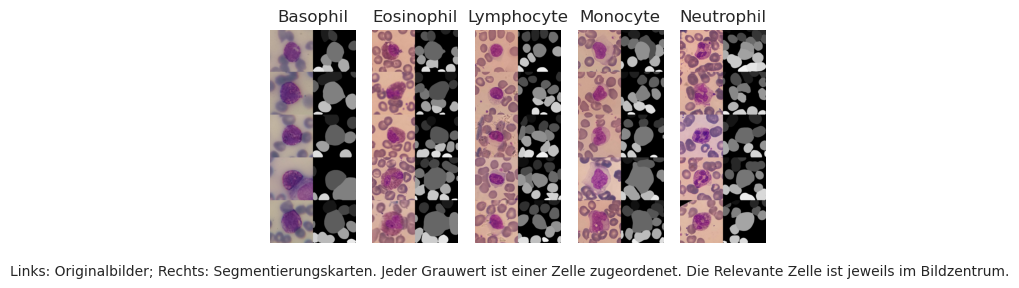

In [198]:
from IPython.display import Image
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# Lade Bilder
img1 = PILImage.open('data/Basophil.png')
img2 = PILImage.open('data/Eosinophil.png')
img3 = PILImage.open('data/Lymphocyte.png')
img4 = PILImage.open('data/Monocyte.png')
img5 = PILImage.open('data/Neutrophil.png')

# Initialisiere Subplots
fig, ax = plt.subplots(1,5)

ax[0].imshow(img1)
ax[0].axis('off') 
ax[0].set_title('Basophil') 
ax[1].imshow(img2)
ax[1].axis('off')
ax[1].set_title('Eosinophil')
ax[2].imshow(img3)
ax[2].axis('off') 
ax[2].set_title('Lymphocyte')
ax[3].imshow(img4)
ax[3].axis('off') 
ax[3].set_title('Monocyte')
ax[4].imshow(img5)
ax[4].axis('off') 
ax[4].set_title('Neutrophil')

# Füge eine Unterschrift zur gesamten Abbildung hinzu
fig.text(0.5, 0.2, 'Links: Originalbilder; Rechts: Segmentierungskarten. Jeder Grauwert ist einer Zelle zugeordenet. Die Relevante Zelle ist jeweils im Bildzentrum.', ha='center', va='bottom')
plt.show()



---

### Übersicht

In [199]:

#------------------------load dataset and get overview----------------------
import pandas as pd
import seaborn as sns
bc_train = pd.read_csv('data/bloodcells_train.csv', sep=";")
bc_train

,image filename,Area,Mean red,StdDev red,Mode red,Min red,Max red,Perim.,Circ.,Feret,...,Min green,Max blue,Max green,Median blue,Median green,Skew blue,Skew green,Kurt blue,Kurt green,Class
0,95-5-10-1_231_1.jpg,36063,101.964,49.394,37,20,187,774.767,0.755,260.967,...,0,183,162,119,53,0.013,0.155,-1.254,-1.707,Neutrophil
1,95-9-4-4_121_1.jpg,6432,97.806,41.106,53,39,190,329.765,0.743,121.672,...,2,161,127,100,23,0.699,0.775,-0.741,-0.863,Neutrophil
2,95-5-4-1_182_1.jpg,32524,156.996,23.149,157,100,251,717.696,0.793,252.242,...,24,186,193,139,55,0.919,1.540,0.531,1.382,Lymphocyte
3,95-8-13-3_60_2.jpg,25293,124.220,47.617,81,54,217,609.955,0.854,213.328,...,0,180,171,124,29,0.148,0.512,-1.438,-1.424,Lymphocyte
4,95-5-10-1_645_2.jpg,44853,167.199,58.149,219,52,239,815.151,0.848,257.329,...,1,202,181,151,123,-0.389,-0.403,-1.333,-1.592,Neutrophil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,95-8-12-5_216_3.jpg,29002,121.817,30.880,98,72,233,637.955,0.895,211.405,...,2,203,181,110,20,0.935,1.299,-0.145,0.284,Lymphocyte
5083,95-8-24-1_231_1.jpg,20568,134.624,25.069,118,99,229,538.701,0.891,176.366,...,3,162,155,94,16,0.881,1.567,-0.269,1.099,Lymphocyte
5084,95-8-10-1_578_1.jpg,46598,163.671,35.299,188,80,223,833.820,0.842,277.723,...,4,178,175,139,113,-0.447,-0.507,-1.003,-1.326,Neutrophil
5085,95-8-20-3_157_1.jpg,16096,155.947,17.368,146,127,207,520.558,0.746,194.610,...,23,176,149,125,46,0.911,0.893,0.266,-0.649,Eosinophil


##### Verständniss der Attribute (interpretation nach ImageJ bezeichnungen):

In [200]:
bc_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image filename  5087 non-null   object 
 1   Area            5087 non-null   int64  
 2   Mean red        5087 non-null   float64
 3   StdDev red      5087 non-null   float64
 4   Mode red        5087 non-null   int64  
 5   Min red         5087 non-null   int64  
 6   Max red         5087 non-null   int64  
 7   Perim.          5087 non-null   float64
 8   Circ.           5087 non-null   float64
 9   Feret           5087 non-null   float64
 10  IntDen          5087 non-null   int64  
 11  Median red      5087 non-null   int64  
 12  Skew red        5087 non-null   float64
 13  Kurt red        5087 non-null   float64
 14  RawIntDen red   5087 non-null   int64  
 15  MinFeret        5087 non-null   float64
 16  AR              5087 non-null   float64
 17  Solidity        5087 non-null   f

##### Visuelle betrachtung der Bilder

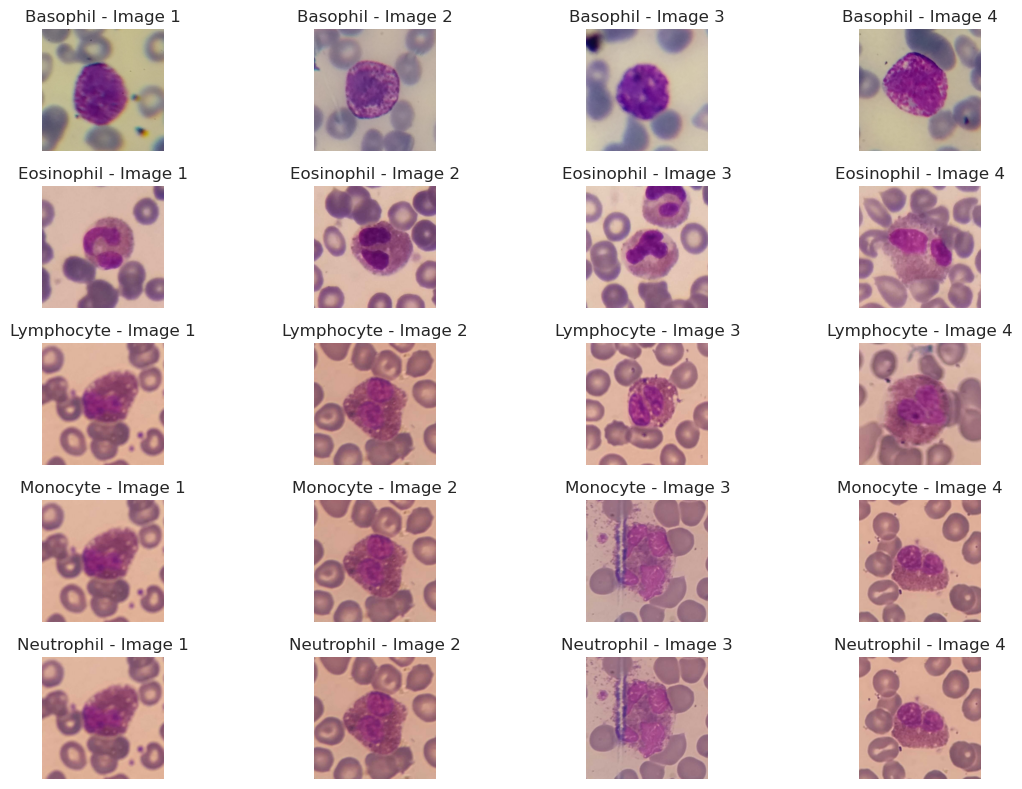

In [201]:
import os
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

base_dir = "data/Images"
folders = ['Basophil', 'Eosinophil','Lymphocyte', 'Monocyte', 'Neutrophil']

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 8))

for i, folder_name in enumerate(folders):
    folder_path = os.path.join(base_dir, folder_name)
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    for j, image_file in enumerate(image_files[:4]):
        image_path = os.path.join(folder_path, image_file)
        img = Image.open(image_path)
        row = i
        col = j
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"{folder_name} - Image {j+1}")
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

##### Die Klassenverteilung betrachten:

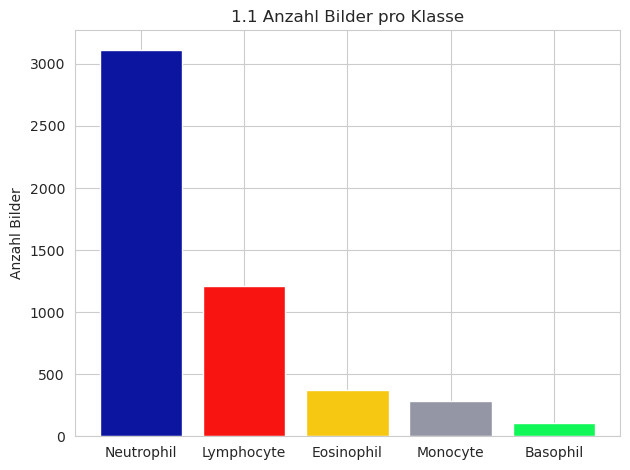

In [202]:
#-------------------Define color palette----------------------
colors = {'Neutrophil': '#0B15A0', 'Eosinophil': '#F7C811', 'Basophil': '#11F758', 'Lymphocyte': '#F71411', 'Monocyte': '#9596A5'}

class_counts = bc_train['Class'].value_counts()

bar_colors = [colors[label] for label in class_counts.index]

plt.bar(class_counts.index, class_counts.values, color=bar_colors)
plt.ylabel('Anzahl Bilder')
plt.title('1.1 Anzahl Bilder pro Klasse')
plt.tight_layout()
plt.show()


Ungleiche Verteilung der Beispiel pro Klasse. Muss in späteren Schritten beachtet werden.

##### Untersuchung der Mittelwerte nach Klasse:

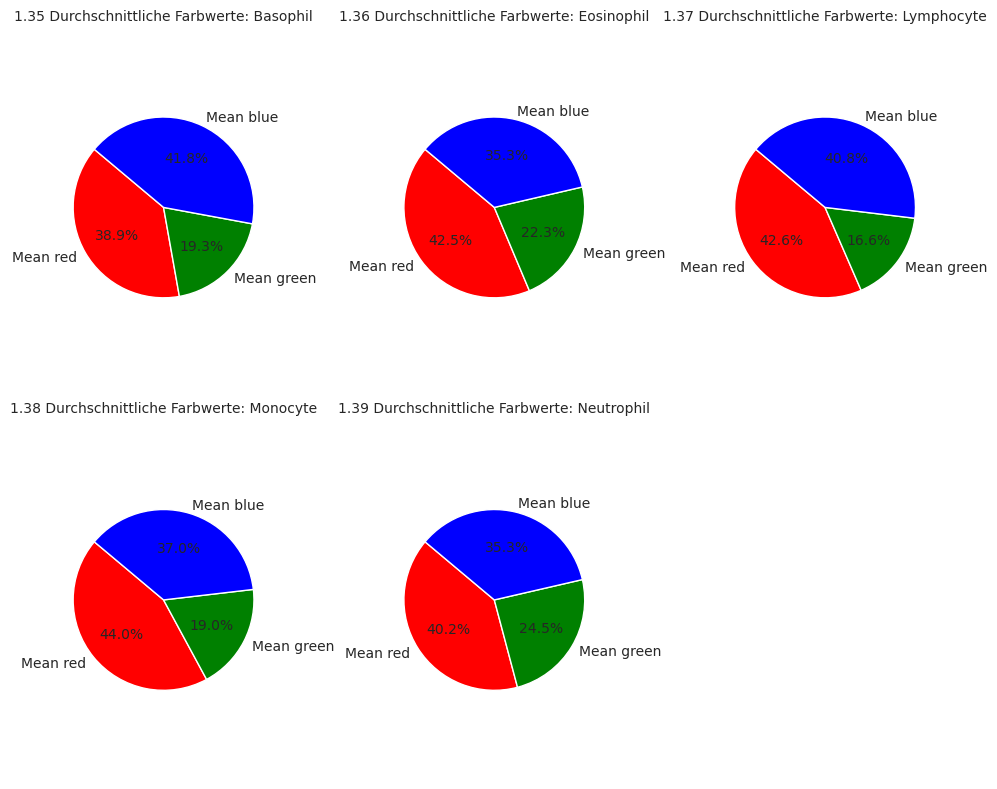

In [207]:
#--------------Mittelwerte der Farbanteile untersuchen------------
colors = {'Mean red': 'red', 'Mean green': 'green', 'Mean blue': 'blue'}

grouped = bc_train.groupby('Class')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

for i, (class_name, group_data) in enumerate(grouped):
    average_values = group_data[['Mean red', 'Mean green', 'Mean blue']].mean()

    row = i // 3
    col = i % 3

    axes[row, col].pie(average_values, labels=average_values.index, autopct="%1.1f%%", startangle=140, colors=colors.values())
    axes[row, col].set_title(f"1.{i+35} Durchschnittliche Farbwerte: {class_name}", fontsize=10)
    axes[row, col].axis('equal')

for i in range(len(grouped), 6):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


1.35-1.37 Es sind keine besenders starke Unterschiede der Mittelwerte der Farbanteile zu erkennen.

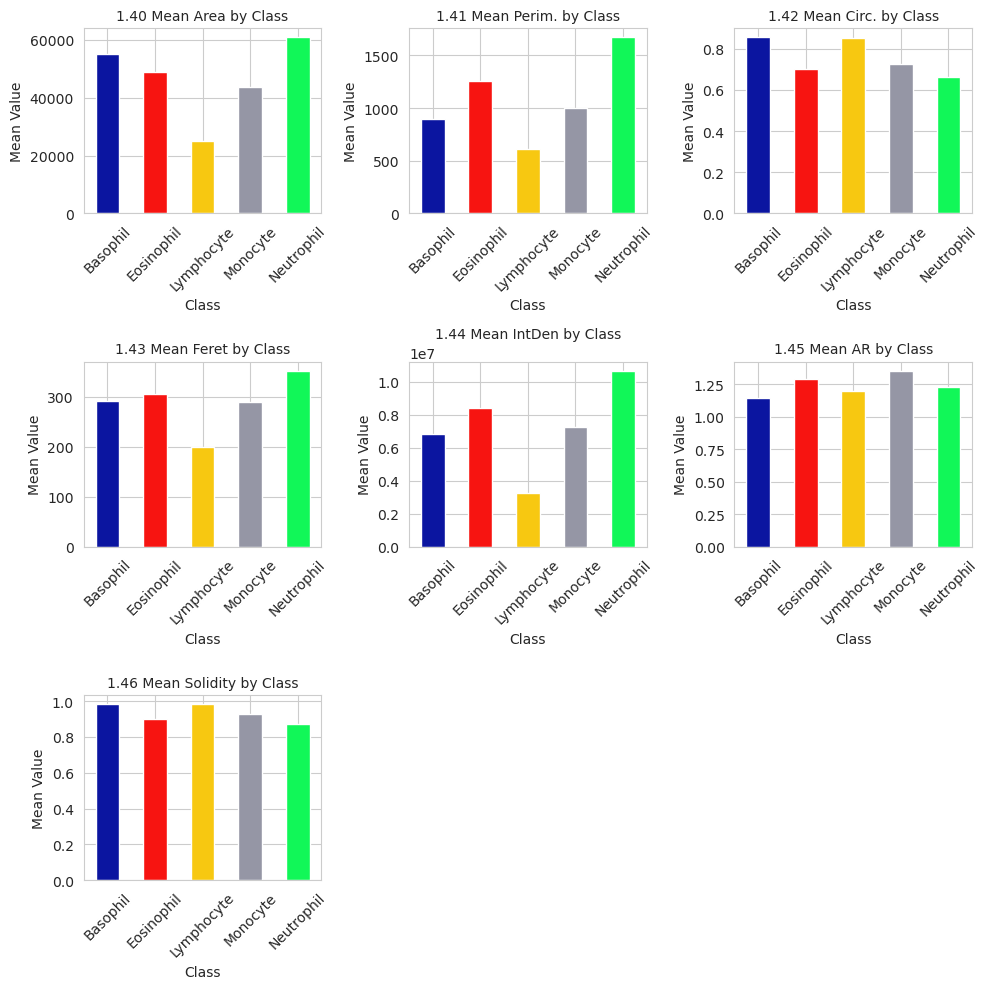

In [208]:
features = ['Area', 'Perim.', 'Circ.', 'Feret', 'IntDen', 'AR', 'Solidity']

#-----------------------Group data and calculate means-----------
class_means = bc_train.groupby('Class')[features].mean()

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(10, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    class_means[feature].plot.bar(ax=ax,color=bar_colors )
    ax.set_ylabel('Mean Value')
    ax.set_title(f'1.{i+40} Mean {feature} by Class', fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    
axes[-1].set_visible(False)
axes[-2].set_visible(False)
plt.tight_layout()
plt.show()

In 1.40, 1.41 & 1.44 ist ein starker Unterschied der Mittelwerte zwischen den Klassen, insbesondere den Lymphozyten & Neutrophilen zu erkennen. Diese Attribute werden daher wahrscheinlich stärker Gewichtet. Bei den restlichen Attributen ist ein Unterschied zu erkennen, dieser ist jedoch nicht ganz so stark.


### Testdaten 

In [209]:
### BEGIN SOLUTION
#------------------------load dataset and get overview----------------------
import pandas as pd
import seaborn as sns
bc_test = pd.read_csv('data/bloodcells_test.csv', sep=";")
bc_test

,image filename,Area,Mean red,StdDev red,Mode red,Min red,Max red,Perim.,Circ.,Feret,...,Min green,Max blue,Max green,Median blue,Median green,Skew blue,Skew green,Kurt blue,Kurt green,Class
0,95-5-5-1_144_1.jpg,36006,185.347,18.313,170,143,231,875.879,0.590,282.986,...,31,166,169,131,97,0.307,0.056,-0.741,-1.471,Eosinophil
1,95-8-10-1_644_2.jpg,20943,109.698,46.423,70,51,233,562.299,0.832,196.492,...,0,178,160,91,15,0.739,1.644,-0.337,1.599,Lymphocyte
2,95-8-1-1_757_2.jpg,246847,195.656,33.860,210,55,224,4217.503,0.174,813.173,...,0,197,190,169,177,-2.249,-2.478,4.419,5.165,Neutrophil
3,95-8-10-1_496_1.jpg,48803,178.445,34.258,209,91,231,834.649,0.880,259.417,...,9,175,176,138,121,-0.432,-0.492,-0.957,-1.351,Neutrophil
4,95-8-3-1_205_1.jpg,20789,112.581,28.582,102,71,209,548.742,0.868,181.532,...,4,174,158,111,19,0.893,1.661,-0.095,1.705,Lymphocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5083,95-7-24-2_278_1.jpg,19946,138.723,26.227,123,73,224,536.399,0.871,182.455,...,4,176,157,114,24,0.872,1.580,0.282,1.626,Lymphocyte
5084,95-8-10-1_497_1.jpg,22352,128.748,39.268,161,56,200,603.477,0.771,205.361,...,5,172,175,140,96,-0.276,-0.153,-1.136,-1.506,Neutrophil
5085,95-8-22-2_25_1.jpg,19346,116.282,36.247,82,69,210,669.193,0.543,226.808,...,8,181,163,109,25,1.003,1.246,0.109,0.194,Neutrophil
5086,95-8-8-2_221_1.jpg,24972,120.121,40.471,86,65,245,600.198,0.871,184.391,...,4,192,195,113,22,0.574,0.927,-1.197,-0.592,Lymphocyte


In [210]:
bc_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5088 entries, 0 to 5087
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image filename  5088 non-null   object 
 1   Area            5088 non-null   int64  
 2   Mean red        5088 non-null   float64
 3   StdDev red      5088 non-null   float64
 4   Mode red        5088 non-null   int64  
 5   Min red         5088 non-null   int64  
 6   Max red         5088 non-null   int64  
 7   Perim.          5088 non-null   float64
 8   Circ.           5088 non-null   float64
 9   Feret           5088 non-null   float64
 10  IntDen          5088 non-null   int64  
 11  Median red      5088 non-null   int64  
 12  Skew red        5088 non-null   float64
 13  Kurt red        5088 non-null   float64
 14  RawIntDen red   5088 non-null   int64  
 15  MinFeret        5088 non-null   float64
 16  AR              5088 non-null   float64
 17  Solidity        5088 non-null   f

Es hat keine Null-Werte, was gut ist.
Es hat gleiche grösse wie der Trainingsdatensatz, was nicht gerade ideal ist. Eine bessere Aufteilung wäre 80/20, ich werde dies im folgenden aber nicht neu Aufteilen, da ich davon ausgehe, dass es so gewollt ist.

In [211]:
#nochmals für Vergleich
bc_train.describe()

,Area,Mean red,StdDev red,Mode red,Min red,Max red,Perim.,Circ.,Feret,IntDen,...,Min blue,Min green,Max blue,Max green,Median blue,Median green,Skew blue,Skew green,Kurt blue,Kurt green
count,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5.087000e+03,...,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000
mean,50481.638883,146.920406,35.667879,149.103204,69.550226,221.068017,1337.205372,0.717955,307.756773,8.464791e+06,...,83.956753,6.254177,184.559269,174.383133,131.637114,82.599764,0.014661,0.100848,-0.017415,0.188772
std,45702.772788,30.605221,11.344800,53.218679,28.285755,14.236490,1632.764005,0.265241,201.637119,9.829182e+06,...,13.954525,9.365165,11.884603,16.096887,21.087678,52.649852,0.907740,1.173118,1.726095,2.440377
min,3220.000000,37.819000,8.485000,0.000000,0.000000,156.000000,228.936000,0.029000,79.398000,3.764240e+05,...,0.000000,0.000000,141.000000,108.000000,75.000000,6.000000,-4.293000,-5.085000,-1.711000,-1.864000
25%,24097.000000,126.991500,27.048000,106.000000,49.000000,212.000000,610.018000,0.716000,202.640000,3.133865e+06,...,74.000000,1.000000,177.000000,164.000000,117.000000,34.000000,-0.405500,-0.481500,-1.065500,-1.364000
50%,36493.000000,145.866000,35.841000,161.000000,68.000000,221.000000,753.512000,0.838000,243.822000,5.155505e+06,...,84.000000,4.000000,184.000000,174.000000,129.000000,80.000000,0.042000,0.005000,-0.700000,-0.917000
75%,49862.000000,161.834000,43.874500,190.000000,88.000000,231.000000,866.235000,0.874000,280.102500,7.562943e+06,...,93.000000,8.000000,192.000000,184.000000,141.000000,112.000000,0.696000,1.044500,0.553500,1.182500
max,267360.000000,234.612000,90.441000,251.000000,167.000000,255.000000,7393.481000,0.907000,813.173000,5.423669e+07,...,145.000000,94.000000,234.000000,234.000000,202.000000,209.000000,2.341000,2.856000,19.809000,29.547000


In [212]:
bc_test.describe()

,Area,Mean red,StdDev red,Mode red,Min red,Max red,Perim.,Circ.,Feret,IntDen,...,Min blue,Min green,Max blue,Max green,Median blue,Median green,Skew blue,Skew green,Kurt blue,Kurt green
count,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5.088000e+03,...,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000
mean,50912.831368,146.565710,35.458824,148.557586,69.749607,220.959513,1347.736587,0.715772,308.151752,8.546715e+06,...,84.107901,6.555425,184.640330,174.347681,131.594340,82.280267,0.029354,0.110507,0.009912,0.196566
std,46585.030768,31.298904,11.484670,53.390530,28.802859,14.242940,1648.529974,0.266296,203.086035,9.998642e+06,...,14.377221,10.274322,12.024791,16.370861,21.472997,53.155761,0.920207,1.176281,1.682508,2.346021
min,3824.000000,48.598000,6.085000,9.000000,0.000000,152.000000,233.622000,0.025000,78.006000,3.357400e+05,...,0.000000,0.000000,143.000000,99.000000,77.000000,4.000000,-3.669000,-4.935000,-1.751000,-1.856000
25%,23734.500000,126.367250,26.798500,105.000000,49.000000,212.000000,606.273750,0.711000,200.307000,3.085403e+06,...,74.000000,1.000000,176.000000,164.000000,117.000000,33.000000,-0.402250,-0.479000,-1.062250,-1.357000
50%,36053.000000,144.775000,35.491000,160.000000,68.000000,222.000000,749.172000,0.837000,242.595000,5.126300e+06,...,84.000000,4.000000,184.000000,174.000000,129.000000,79.000000,0.068000,0.011000,-0.664000,-0.874500
75%,50943.750000,162.247250,43.803000,190.000000,89.000000,231.000000,874.746750,0.873000,281.427000,7.743919e+06,...,94.000000,9.000000,192.000000,184.000000,141.000000,112.000000,0.733250,1.090250,0.594500,1.270250
max,249712.000000,228.699000,85.557000,252.000000,175.000000,255.000000,6896.653000,0.906000,813.173000,5.103453e+07,...,133.000000,100.000000,240.000000,236.000000,197.000000,210.000000,2.216000,2.531000,17.784000,28.944000


Hat im Vergleich mit dem Trainingsdatensatz keine extrem auffälligen Werte

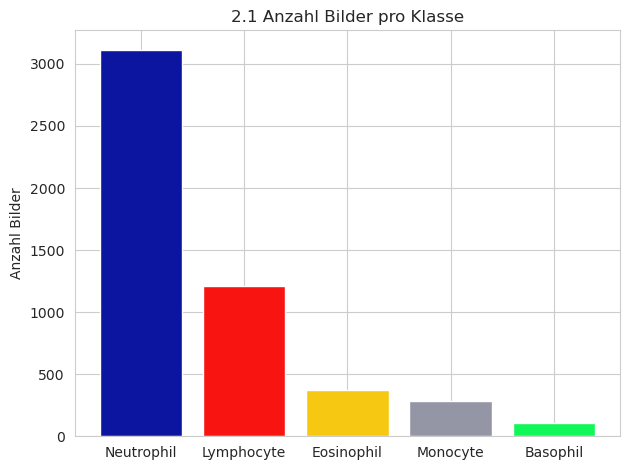

Neutrophil    3116
Lymphocyte    1214
Eosinophil     372
Monocyte       280
Basophil       106
Name: Class, dtype: int64

In [213]:
colors2 = {'Neutrophil': '#0B15A0', 'Eosinophil': '#F7C811', 'Basophil': '#11F758', 'Lymphocyte': '#F71411', 'Monocyte': '#9596A5'}

class_counts2 = bc_test['Class'].value_counts()

bar_colors2 = [colors2[label] for label in class_counts2.index]

plt.bar(class_counts.index, class_counts.values, color=bar_colors2)
plt.ylabel('Anzahl Bilder')
plt.title('2.1 Anzahl Bilder pro Klasse')
plt.tight_layout()
plt.show()
bc_test['Class'].value_counts()


Abbildung 2.1 zeigt, dass die Testklasse etwa eine gleich schlechte Verteilung der Anzahl Bilder pro Klasse hat, wie die Trainingsklasse. Dies wird zu guten Ergebnissen in meinen Tests führen, kann jedoch auch dazu führen, dass mein Modell die Klasse Basophil nicht so gut vorhersagen kann.

### Dummy-Klassifikatoren'

Zuerst werden zwei heuristische Klassifikations-Strategien evaluiert:

1. Einen Dummy-Klassifikator, welcher immer das häufigste Label der Trainingsdaten vorhersagt.
2. Einen Dummy-Klassifikator, welcher ein zufälliges Label vorhersagt, jeweils mit der Wahrscheinlichkeit seines Vorkommens in den Trainingsdaten.


In [214]:
#---------------------------------------- Most frequent ----------------------------------------
def most_frequent_classifier(y_train, y_test):
    """takes the train-dataset, gets the most frequent class in it and creates a dataframe the size of the test-Dataset"""

    class_counts = y_train['Class'].value_counts()
    most_frequent_class = class_counts.idxmax()

    data = {'Class': [most_frequent_class for _ in range(y_test.shape[0])]}
    y_pred = pd.DataFrame(data, index=range(y_test.shape[0]), columns=['Class'])
    return y_pred


#---------------------------------------- random ----------------------------------------

def random_classifier(training_data, y_test):
    """takes the train-dataset, gets the distribution of the classes, creates a dataframe the size of the test-Dataset. Each row has the probability from the train-dataset to contain a class"""
    #------Wahrscheinlichkeiten berechnen------
    label_counts = training_data.value_counts(normalize=True)
    labels = label_counts.index.tolist()  
    probabilities = label_counts.values.tolist()
    #------"Vorhersagen" erstellen
    data = {'Class': [np.random.choice(labels, p=probabilities) for _ in range(y_test.shape[0])]}
    y_pred = pd.DataFrame(data, index=range(y_test.shape[0]), columns=['Class'])
    #print(y_pred.value_counts())
    return y_pred
#---------------------------------------- accuracy ----------------------------------------

def accuracy(y_true, y_pred):
    '''Takes two Dataframes and calculates Accuracy'''
    correct_predictions = (y_true['Class'] == y_pred['Class']).sum()
    return correct_predictions.sum() / len(y_pred)

#---------------------------------------- F1-Score ----------------------------------------

def f1_score(y_true, y_pred):
    """calculate f1-score of two Dataframes"""
    classes = y_true['Class'].unique().tolist()

    f1_scores =[]
    for class_name in classes:
        tp = ((y_true['Class'] == y_pred['Class']) & (class_name == y_pred['Class'])).sum()
        fp = ((y_true['Class'] != y_pred['Class']) & (class_name == y_pred['Class'])).sum()
        fn = ((y_true['Class'] != y_pred['Class']) & (class_name != y_pred['Class'])).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_scores.append( 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0)
    
    return np.mean(f1_scores)

#-------------------------Load data----------------------
train2 = bc_train.copy()
test2 = bc_test.copy()

#-------------Dummy 1--------------------
frequentPred = most_frequent_classifier(train2, test2)
frequ_accuracy = accuracy(test2, frequentPred)
frequ_f1 = f1_score(test2, frequentPred)

#-------------Dummy 2--------------------
randomPred = random_classifier(train2['Class'], test2)
randomAcc = accuracy(test2, randomPred)
randomF1 = f1_score(test2, randomPred)

print("Dummy 1: Häuffigstes Label Classifier:")
print(f'Overall Accuracy: {frequ_accuracy}')
print(f'F1-Sccore: {frequ_f1}')

print("--------------------------------------")

print("Dummy 2: Wahrscheinlichkeits Classifier:")
print(f'Overall Accuracy: {randomAcc}')
print(f'F1-Sccore: {randomF1}')

Dummy 1: Häuffigstes Label Classifier:
Overall Accuracy: 0.6124213836477987
F1-Sccore: 0.15192588980984884
--------------------------------------
Dummy 2: Wahrscheinlichkeits Classifier:
Overall Accuracy: 0.4435927672955975
F1-Sccore: 0.1571873515860462


###### Diskussion:
Beim ersten Dummy Klassifikator wird vorallem deutlich, wie Unterschiedlich die Accuracy und der F1-Score die Güte eines Modells bestimmen. Bei wenigen Klassen oder einer schlechten Klassenverteilung wie hier, lässt die Accuracy das Modell besser erscheinen als es ist. 
Der F1-Score ist eine Mischung zwischen Precision, bei welcher False Positives stark negativ gewichtet werden und Recall, bei welchem False Negatives stark gewichtet werden. Durch deren höhere Gewichtung, hat die hohe Anzahl an TP nicht mehr eine solch starke Gewichtung und das Modell bekommt einen tieferen Score. 

Beim Dummy 2 können sich Accuracy und F1 je nach durchlauf verändern. Die Accuracy bleibt nach jedem Durchlauft ungefähr bei 44% und der F1 ca. bei 15%. Wieder zeigt sich dass die Accuracy nicht sehr Aussagekräftig ist, da dass Modell eigentlich bereit 'intelligenter' ist als Dummy 1 aber eine deutlich schlechtere Accuracy erreicht. Der F1-Score bleibt tief, da immernoch viele FP und FN sind

### Logistic Regression

Als Baseline-Modell zur Vorhersage der Blutzellentypen wird logistische Regression verwendet.  

In [215]:
#---------------------------------------- Plot Confusion Matrix ----------------------------------------
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):

    unique_classes = np.unique(np.concatenate((y_true, y_pred)))
    class_count = len(unique_classes)
    class_to_index = {class_name: index for index, class_name in enumerate(unique_classes)}
    cm = np.zeros((class_count, class_count), dtype=int)

    for true, pred in zip(y_true, y_pred):
        cm[class_to_index[true], class_to_index[pred]] += 1

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(unique_classes))
    plt.xticks(tick_marks, unique_classes, rotation=45)
    plt.yticks(tick_marks, unique_classes)
    #numbers in the confusion matrix:
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
#---------------------------------------- Accuracy ----------------------------------------    
def overallAccuracy(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """ Calculate Accuracy of arrays """
    score = np.mean(X == y)
    return score
#---------------------------------------- F1-Score ----------------------------------------
def f1_score_ndarray(y_true, y_pred, classes):
    f1_scores =[]
    for class_name in classes:
        tp = ((y_true == y_pred) & (class_name == y_pred)).sum()
        fp = ((y_true != y_pred) & (class_name == y_pred)).sum()
        fn = ((y_true != y_pred) & (class_name != y_pred)).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_scores.append( 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0)

    return np.mean(f1_scores)

Overall Accuracy: 0.6238207547169812
F1-Score: 0.17926038762237698


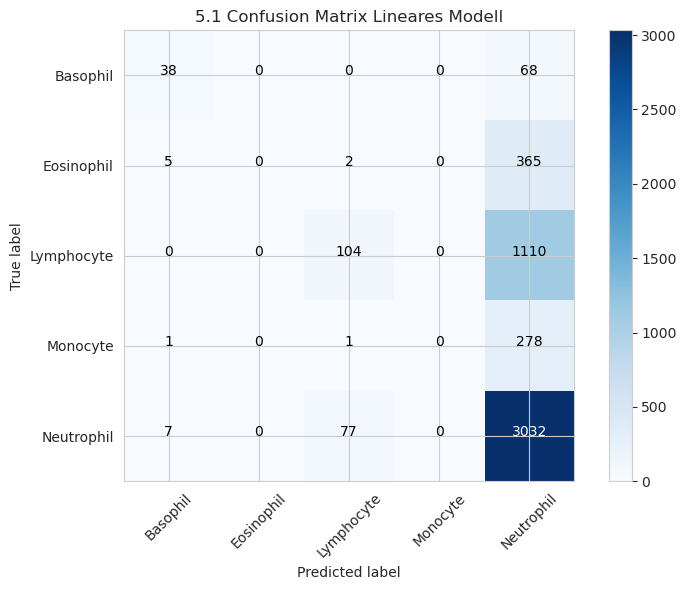

None


In [216]:
### BEGIN SOLUTION
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

train5 = bc_train.copy()
test5 = bc_test.copy()

X_train = train5.drop('Class', axis=1).drop('image filename', axis=1)
y_train = train5.Class
X_test = test5.drop('Class', axis=1).drop('image filename', axis=1)
y_test = test5["Class"].values

classes = ['Basophil', 'Eosinophil','Lymphocyte', 'Monocyte', 'Neutrophil']
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# ----------------------Initialisiere das Modell mit bestem f1-----------------
model = LogisticRegression(penalty='l2', solver='liblinear')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_macro')
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
time5 = end_time - start_time

# -----------Beste Parameter und Modell trainieren-----------
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

#-----------predict-----------
y_pred = best_model.predict(X_test)

#-----------accuracy and f1-------------------
accuracy = overallAccuracy(y_test, y_pred)
f1_5 = f1_score_ndarray(y_test, y_pred, classes)

print("Overall Accuracy:", accuracy)
print("F1-Score:", f1_5)
# ------------Confusion Matrix------------------
confusion = plot_confusion_matrix(y_test, y_pred, "5.1 Confusion Matrix Lineares Modell")
print(confusion)
### END SOLUTION

Abbildung 5.1 zeigt ein Lineares Modell welches auf unsere Daten getestet wurde, mit verschiedenen Werten für den Paramter 'C', welcher das Mass für Overfitting/Underfitting beeinflusst.

Das Modell hat einen ähnliche Accuracy wie der Dummy 1 aus Aufgabe 4 aber einen leicht besseren F1-Score als beide vorherigen Dummies. Jedoch immernoch sehr schlecht. In der Confusion Matrix ist zu erkennen, dass er die meisten als Neutrophile klassifiziert und noch ein paar wenige Basophile und Lymphozyten richtig vorhersagt. Keine der Vorhersagen wurde als Eosinophil oder Monocyt klassifiziert.



### Multi-Layer Perceptron 

Nun wird ein Multi-Layer Perceptron mit Sigmoid Aktivierungsfunktionen zur Multi-Klass Klassifikation implementiert.


In [218]:
import copy
import time
import numpy as np
import math
import seaborn as sns
from itertools import islice
from typing import List, Tuple, Union, Iterable

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder

import matplotlib.animation as animation

class MLPClassifier(BaseEstimator):
    def __init__(
            self,
            num_nodes_per_layer: List[int],
            lr: float = 0.01,
            alpha: float = 0.0,
            batch_size: Union[int, None] = None,
            max_num_steps: int = 1000,
            weights_init_range: Tuple[float, float] = (-0.7, 0.7),
            adaptive_lr_constant: float = 0.0,
            min_lr: float = 1e-4,
            random_seed: int = 123,
            target_cost =0
    ):

        self.random_seed = random_seed
        self.num_layers = len(num_nodes_per_layer)
        self.num_nodes_per_layer = num_nodes_per_layer
        self.lr = lr
        self.alpha = alpha
        self.batch_size = batch_size
        self.max_num_steps = max_num_steps
        self.weights_init_range = weights_init_range
        self.adaptive_lr_constant = adaptive_lr_constant
        self.min_lr = min_lr
        self.target_cost = target_cost

        self.cost_ = []
        self.weights_ = []
        self._initialize_weights()
        self.snapshots = []

        ### END SOLUTION

    def _initialize_weights(self):
        """ Initialize Model-Parameters W """
        ### BEGIN SOLUTION
        np.random.seed(self.random_seed)
        for i in range(1, len(self.num_nodes_per_layer)):
            W = np.random.uniform(self.weights_init_range[0], self.weights_init_range[1],
                                  size=(self.num_nodes_per_layer[i - 1] + 1, self.num_nodes_per_layer[i]))
            self.weights_.append(W)
        ### END SOLUTION

    def forward(self, X: np.ndarray) -> List[np.ndarray]:
        """ forward pass - calculate all activations
            Args:
                X: Input-Activations [num_samples, num_features]
    
            Returns: List of Layer-Activations
        """
        ### BEGIN SOLUTION
        activations = [X]
        X = np.hstack([np.ones((X.shape[0], 1)), X])        #Bias      
        for i, weights in enumerate(self.weights_):
            z = X @ weights

            if i < len(self.weights_) - 1:                  #l<L
                a = self.sigmoid(z)
            else:                                           #l=L
                a = self.softmax(z)

            X = np.hstack([np.ones((a.shape[0], 1)), a])
            activations.append(a)

        return activations

    ### END SOLUTION

    def backward(self, activations: List[np.ndarray], delta_upstream: np.ndarray) -> List[np.ndarray]:
        """ backward pass / backpropagation - Calculate partial derivatives of model weights
            Args:
                activations: List of Layer Activations, Output of forward()
        
                delta_upstream: Matrix with partial derivatives of Loss functions wrt. 
                    logits of last layer[num_samples, num_outputs]
    
            Returns: List of Layer-Gradients
        """
        ### BEGIN SOLUTION
        samples = delta_upstream.shape[0]
        gradients = [np.zeros_like(W) for W in self.weights_]  # Initialize gradients

        delta = delta_upstream
        #------backprop-Schritte für l<L------
        for i in reversed(range(len(self.num_nodes_per_layer) - 1)):
            layer_activation = activations[i]
            activation_with_bias = np.insert(layer_activation, 0, 1, axis=1)         # Add bias term to activations

            gradients[i] = activation_with_bias.T @ delta / samples                 # "Dies sind die Gradienten der Gewichte!"

            if i > 0:                                                               # Calculate delta for the next layer               
                weights_without_bias = self.weights_[i][1:]                         # Exclude bias from weights  
                d_sigmoid = layer_activation * (1 - layer_activation)               # Deriv of sigmoid

                delta = delta @ weights_without_bias.T * d_sigmoid                  # Propagate the error back to the previous layer

        # ------L2 regularization------
        if self.alpha > 0:
            for i in range(len(gradients)):
                gradients[i] += self.alpha * self.weights_[i]

        return gradients
    ### END SOLUTION

    def fit(
            self,
            X: np.ndarray, y: np.ndarray,
            X_val: Union[np.ndarray, None] = None,
            y_val: Union[np.ndarray, None] = None,
            partial=False,
            validate_after_every_num_steps: int = 20) -> None:

        """ Fit Model Parameters
            Args:
                X, y: Training-Data
                X_val, y_val: (Optional) Validation-Data
                validate_after_every_num_steps: (Optional) Validation after every xth step
        """
        ### BEGIN SOLUTION
        batches = self.generate_batches(X, y, self.batch_size)
        for step in range(1, self.max_num_steps + 1):
            if self.batch_size is not None:
                self.partial_fit(batches, (X.shape[0] / (self.batch_size)).__ceil__(), step)
            else:
                self.partial_fit(batches, (X.shape[0] / X.shape[0]).__ceil__(), step)
            if self.cost_[-1] < self.target_cost:
                break
                # else next batch


            #ToDo: Validation 
            if step % validate_after_every_num_steps == 0:
                if X_val is not None and y_val is not None:
                    y_val_pred = self.predict_proba(X_val)
                    val_loss = self.calculate_cost(y_val, y_val_pred)
                    print(f"Validation Loss after {step} steps: {val_loss}")


    def partial_fit(self, batch, numberB, step):
        total_cost = 0
        for _ in range(numberB):
            X_batch, y_batch = next(batch)
            #------forward------
            activations = self.forward(X_batch)
            y_pred = activations[-1]
            #------backward------
            delta_upstream = self.calculate_gradient_of_cost_function(y_batch, y_pred)      #initialisierung (y_pred-y)
            gradients = self.backward(activations, delta_upstream)
            lr = max(self.min_lr, self.lr * np.exp(-self.adaptive_lr_constant * step))

            for i, weight in enumerate(self.weights_):
                self.weights_[i] -= lr * gradients[i]

            total_cost += self.calculate_cost(y_batch, y_pred)


        average_cost = total_cost / numberB
        self.cost_.append(average_cost)

        ### END SOLUTION

    def calculate_cost(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """ Calculate Cross-Entropy cost """
        ### BEGIN SOLUTION
        n = y_true.shape[0]
        loss = (1/n) * np.sum(-y_true * np.log(y_pred))
        c =  (self.alpha/2) * sum(np.sum(W**2) for W in self.weights_)
        return loss + c
        ### END SOLUTION

    def calculate_gradient_of_cost_function(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """ Calculate gradient of cost function w.r.t logits dJ/dZ """
        ### BEGIN SOLUTION
        return y_pred - y_true
        ### END SOLUTION

    def softmax(self, x: np.ndarray) -> np.ndarray:
        """ Softmax along last dimension: x is of shape [num_samples, num_classes] """
        ### BEGIN SOLUTION
        expZ = np.exp(x - np.max(x, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)
        ### END SOLUTION

    def sigmoid(self, x: np.ndarray) -> np.ndarray:
        """ Sigmoid activation function """
        ### BEGIN SOLUTION
        return 1 / (1 + np.exp(-x))
        ### END SOLUTION

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """ All class probabilities per sample
            -> input shape  [num_samples, num_features]
            -> output shape [num_samples, num_classes]
        """
        activations = self.forward(X)
        probabilities = activations[-1]
        return probabilities

    def predict(self, X: np.ndarray, hot=False) -> np.ndarray:
        """ Return most likely class per sample
           -> input shape  [num_samples, num_features]
           -> output shape [num_samples, 1]
        """
        probabilities = self.predict_proba(X)

        if hot:
            max_indices = probabilities.argmax(axis=1)
            result = np.zeros_like(probabilities)
            result[np.arange(len(probabilities)), max_indices] = 1
            return result
        else:
            predictions = np.argmax(probabilities, axis=1)
            predictions = predictions.reshape(-1, 1)
            return predictions

    def score(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """ Calculate Accuracy """
        ### BEGIN SOLUTION
        y_pred_hot = self.predict(X, hot=True)
        score = np.mean(y_pred_hot == y)
        return score
        ### END SOLUTION

    #-------------------------------------------------------------------------------
    def generate_batches(
            self, X: np.ndarray, y: np.ndarray,
            batch_size: Union[int, None],
            shuffle: bool=True) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """ Generate batches of data [BATCH_SIZE, NUM_FEATURES]"""

        # Batch Gradient Descent
        if not batch_size:
            batch_size = X.shape[0]
            while True:
                yield X, y

        # Flexible Batch-Size that works with batch_size != None
        while True:
            # randomly shuffle input data
            shuffled_indices = np.arange(X.shape[0])
            if shuffle:
                np.random.shuffle(shuffled_indices)

            # iterate over batches
            iter_indices = np.arange(X.shape[0])
            slices = islice(iter_indices, 0, None, batch_size)

            # select batches
            for start_index in slices:
                indices_to_select = shuffled_indices[start_index: start_index+batch_size]
                yield X[indices_to_select, :], y[indices_to_select, :]

    def grad_check(
            self, X: np.ndarray, y: np.ndarray,
            epsilon: float=0.0001,
            decimal: int=3,
            verbose: bool=False) -> None:
        """Compare the gradient with finite differences around current point in parameter space
            Args:
                X, y: Data
                epsilon: step to take around current parameters
                decimal: verify equality if approximaton is within +- 1e-<decimal>
        """
        self.costs = []             #for visual comparison of costs
        # calculate gradient
        activations = self.forward(X)
        y_hat = activations[-1]
        delta_upstream = self.calculate_gradient_of_cost_function(y, y_hat)
        gradients = self.backward(activations, delta_upstream)


        # approximate gradient
        gradients_approx = copy.deepcopy(gradients)
        original_layers = copy.deepcopy(self.weights_)
        #print(f'-------{self.weights_}')
        # Iterate over each parameter of the network
        for i, weights in enumerate(self.weights_):
            for j, _ in enumerate(weights[0].flat):

                # generate copy of original parameters for modification
                modified_layers = copy.deepcopy(original_layers)

                # assign modified layers for use in other methods
                self.weights_ = modified_layers

                # J(theta + epsilon)
                modified_layers[i][0].flat[j] += epsilon
                y_hat = self.predict_proba(X)
                cost_plus_epsilon = self.calculate_cost(y, y_hat)

                # J(theta - epsilon)
                modified_layers[i][0].flat[j] -= 2 * epsilon
                y_hat = self.predict_proba(X)
                cost_minus_epsilon = self.calculate_cost(y, y_hat)

                # Approx gradient with:
                # (J(theta + epsilon) - J(theta - epsilon)) / (2 * epsilon)
                grad_approx = (
                        (cost_plus_epsilon - cost_minus_epsilon) /
                        (2 * epsilon))

                gradients_approx[i][0].flat[j] = grad_approx

        # reset layers attribute
        self.weights_ = copy.deepcopy(original_layers)

        # normalize gradients
        gradients_approx = [x / np.linalg.norm(x) for x in gradients_approx[:][0]]
        gradients = [x / np.linalg.norm(x) for x in gradients[:][0]]

        #self.plot_gradient("Costs of Gradient Check")
        if verbose:
            print('approx : ', gradients_approx[0])
            print('calc : ', gradients[0] )


        #for w in self.weights_:
        #    print(len(w))
        #   print(w[0].shape)
        for approx, calculated in zip(gradients_approx, gradients):
            np.testing.assert_array_almost_equal(approx, calculated, decimal=decimal)
        print(f"Gradients within +- 1e-{decimal} of approximated gradient!")



    # Additional Methods for your convenience (optional)
    ### BEGIN SOLUTION
    def plot_gradient(self, func):
        plt.figure()
        plt.plot(self.cost_)
        plt.xlabel("steps")
        plt.ylabel("Kosten")
        plt.title(func)
        plt.show()

    def plot_confusion_matrix_multiclass(self, y_true, y_pred, class_labels, title="Confusin Matrix"):
        """Plots a confusion matrix for multiclass classification.   
        Args:
            y_true: True labels (one-hot encoded).
            y_pred: Predicted labels (not one-hot encoded).
            class_labels: List of class labels.
            title: title of the Matrix: -> "Confusion Matrix"
        """
        y_true_labels = np.argmax(y_true, axis=1)

        # -------Calculate the confusion matrix-------
        num_classes = len(np.unique(y_true_labels))
        cm = np.zeros((num_classes, num_classes), dtype=int)

        for true_label, pred_label in zip(y_true_labels, y_pred):
            cm[true_label, pred_label] += 1

        # ------- plot -------
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
        plt.title(title)
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()



    def f1_score(self, y_true, y_pred):
        """
        Parameters:
        y_true (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.
        Returns:
        float: F1 score.
        """
        # get true positives, false positives, and false negatives
        tp = np.sum(np.logical_and(y_true == 1, y_pred == 1))
        fp = np.sum(np.logical_and(y_true == 0, y_pred == 1))
        fn = np.sum(np.logical_and(y_true == 1, y_pred == 0))

        # # Calculate F1 score
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        return f1

Anhand des kleinen Entwicklungsdatensatzes (dev_data.csv) wird gezeigt, dass die Implementierung funktioniert, indem die Output-Variable $y \in {0, 1, 2}$ anhand der Input-Variablen $\mathbf{x} = \left(x_1, x_2\right)$ vorhergesagt werden kann. Dazu wird ein Netzwerk mit 2 Hidden Layern mit je 20 Units/Nodes plus Bias Unit erzeugt und die Modell-Koeffizienten optimiert werden.


Overall Accuracy: 0.9444444444444444


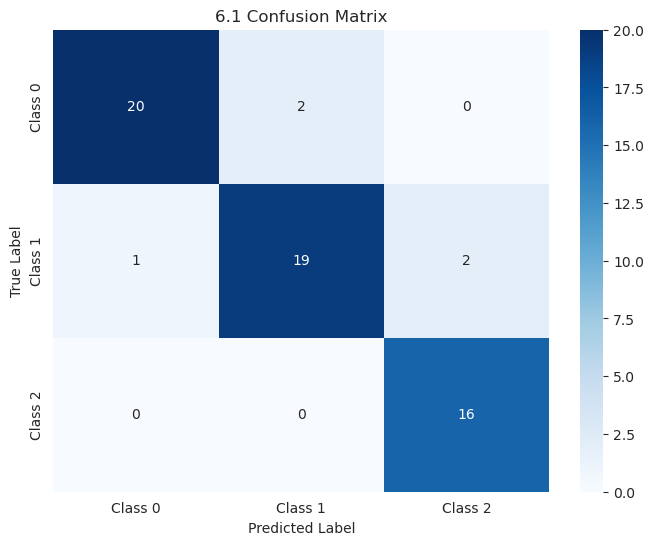

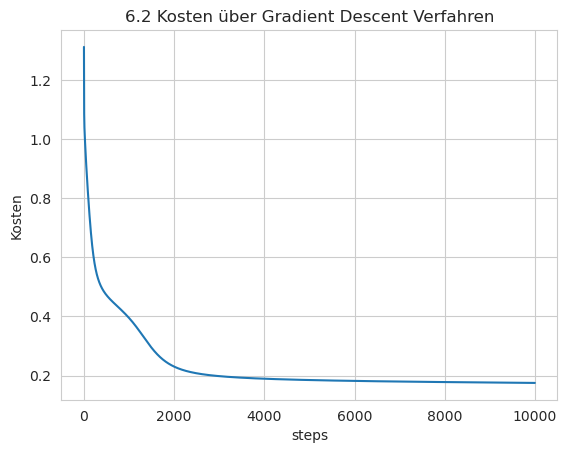

Gradients within +- 1e-3 of approximated gradient!


In [219]:
import pandas as pd
from sklearn.model_selection import train_test_split
### BEGIN SOLUTION
#-------------Prepare Data----------------
data = pd.read_csv("data/dev_data.csv")
X = data.drop("y", axis=1).values  # Input features
y = data["y"].values  # Output variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#-------------oneHotEncode y_true-------------
encoder = OneHotEncoder(sparse=False)  # Create one-hot encoder (sparse=False) or (sparse_output)???
y_traintrue = encoder.fit_transform(y_train.reshape(-1, 1))
y_testtrue = encoder.fit_transform(y_test.reshape(-1, 1))


# -------------Modell hidden layers with 20 nodes each and output layer with 3-------------
mlp = MLPClassifier(num_nodes_per_layer=[2, 20, 20, 3], alpha=0.00, lr=0.1, max_num_steps=10000)

# -------------fit---------------
mlp.fit(X_train, y_traintrue)
score = mlp.score(X_test,y_testtrue)
print(f'Overall Accuracy: {score}')

#---------------draw Confusion Matrix-------------
y_pred = mlp.predict(X_test, hot=False)
class_labels = ["Class 0", "Class 1", "Class 2"]
mlp.plot_confusion_matrix_multiclass(y_testtrue, y_pred, class_labels, title="6.1 Confusion Matrix")

#------------plot gradient------
mlp.plot_gradient("6.2 Kosten über Gradient Descent Verfahren")
mlp.grad_check(X_train, y_traintrue)
### END SOLUTION

6.3 zeigt die Decision Regions des Modells nach den Anzahl Steps. Das Model ist ideal, wenn der Hintergrund (Decision Region) überall mit den den Farben der Punkte übereinstimmt. <br>
Bei den niedrigen Steps ist zu sehen, dass die Regionen sich zuerst sehr Grob zuordnen und dann nach mehr Steps nur noch feine Anpassungen der Regionen stattfinden um mehr Punkte richtig zuzuordnen.
(Falls es animation nicht zeigt, ist sie auf jedenfall als Datei im Ordner zu sehen)

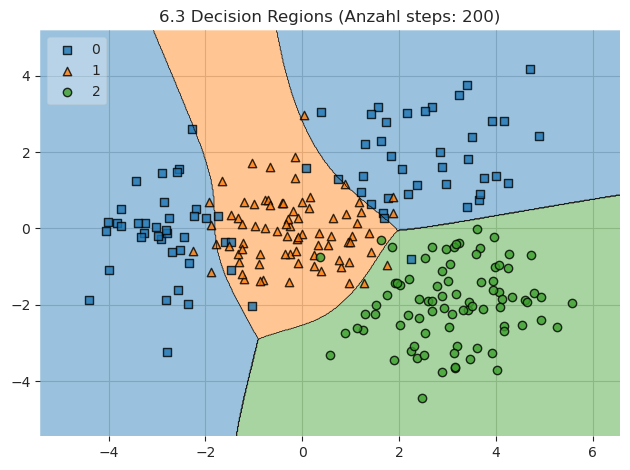

In [220]:
from matplotlib.animation import FuncAnimation, PillowWriter
from mlxtend.plotting import plot_decision_regions
max_steps=200
clf = MLPClassifier(num_nodes_per_layer=[2, 20, 20, 3], max_num_steps=max_steps)

fig, ax = plt.subplots()
fig.set_tight_layout(True)
step = 0
def animate(i):
    global step
    ax.clear()
    if step < max_steps:
        clf.fit(X_train, y_traintrue)
        step += 1
    plot_decision_regions(X_train, y_train.astype(np.int_), clf=clf, legend=2, ax=ax)
    ax.set_title(f'6.3 Decision Regions (Anzahl steps: {step})')
    return ax,

# Erstelle die Animation
anim = FuncAnimation(fig, animate, frames=max_steps, repeat=True)

# Speichere das animierte GIF
writer = PillowWriter(fps=15,metadata=dict(artist='Raphael Meier'),bitrate=1800)
anim.save("DecisionRegions2.gif", writer=writer)
plt.show()

In dieser Aufgabe wird deine MLP-Implementierung verwendet, um ein Modell für die Vorhersage der Blutzellentypen zu entwickeln.


In [222]:
### BEGIN SOLUTION
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
train7 = bc_train.copy()
test7 = bc_test.copy()

Xtrain7 = train7.drop(["Class", "image filename"], axis=1).values
Xtrain7df = train7.drop(["Class", "image filename"], axis=1)

ytrain7 = train7["Class"].values  # Output variable

Xtest7 = test7.drop(["Class", "image filename"], axis=1).values   # Input features
ytest7 = test7["Class"].values  # Output variable

#-------------oneHotEncode y_true-------------
encoder = OneHotEncoder(sparse=False)  # Create one-hot encoder (sparse=False) or (sparse_output)???
y_train_hot7 = encoder.fit_transform(ytrain7.reshape(-1, 1))
y_test_hot7 = encoder.fit_transform(ytest7.reshape(-1, 1))

# -------------Standardize input features with two diffrent Scalers-------------
s_scaler = StandardScaler()
Xtrain7_scaled = s_scaler.fit_transform(Xtrain7)
Xtest7_scaled = s_scaler.fit_transform(Xtest7)

mm_scaler = MinMaxScaler()
Xtrain7_mm_scaled = mm_scaler.fit_transform(Xtrain7)
Xtest7_mm_scaled = mm_scaler.fit_transform(Xtest7)

In [223]:
param_grid = {
    'alpha': [0.00001, 0.0001],
    'num_nodes_per_layer': [[33, 20, 20, 5], [33, 30, 10, 5], [33, 30, 5], [33, 10, 20, 10, 5]],
    'lr': [1.,0.1,0.01],
}   #max steps wird je grösser desto besser daher weggelassen

# -------Custom Grid Search--------
best_params = None
best_f1 = -1

for alpha in param_grid['alpha']:
    for lr in param_grid['lr']:
        for num_nodes_per_layer in param_grid['num_nodes_per_layer']:
            f1_scores = []
            mlp = MLPClassifier(num_nodes_per_layer=num_nodes_per_layer, alpha=alpha, max_num_steps=1000, lr=lr, batch_size=500)
            mlp.fit(Xtrain7_scaled, y_train_hot7)
            y_pred = mlp.predict(Xtest7_scaled, hot=True)
            f1_scores.append(mlp.f1_score(y_test_hot7, y_pred))

            avg_f1 = np.mean(f1_scores)
            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_params = {'alpha': alpha, 'lr': lr, 'num_nodes_per_layer': num_nodes_per_layer}

# Best model and its score
print(f'Beste Parameter: {best_params}' )
print(f'Best F1: {best_f1}')


Beste Parameter: {'alpha': 0.0001, 'lr': 1.0, 'num_nodes_per_layer': [33, 30, 5]}
Best F1: 0.9467374213836478


##### Bestes Modell nach F1:

Accuracy of standard-scaled data: 0.967059748427673
F1 of standard-scaled data: 0.9176493710691824
---------------------------------------------
Accuracy of MinMax-scaled data : 0.941745283018868
F1 of MinMax-scaled data: 0.8543632075471698


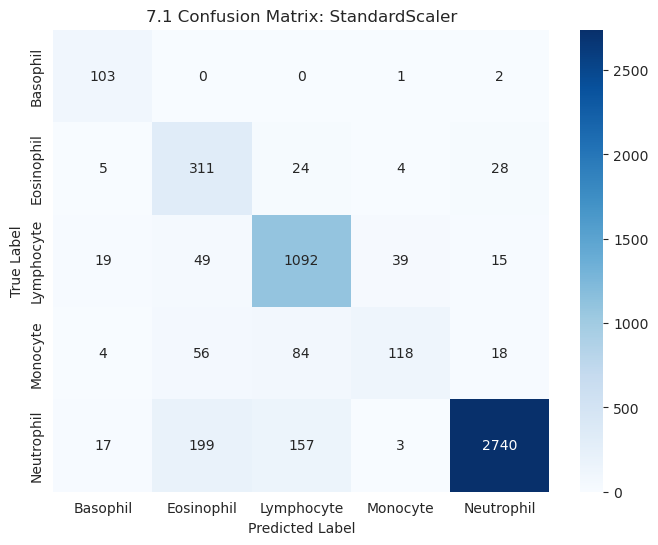

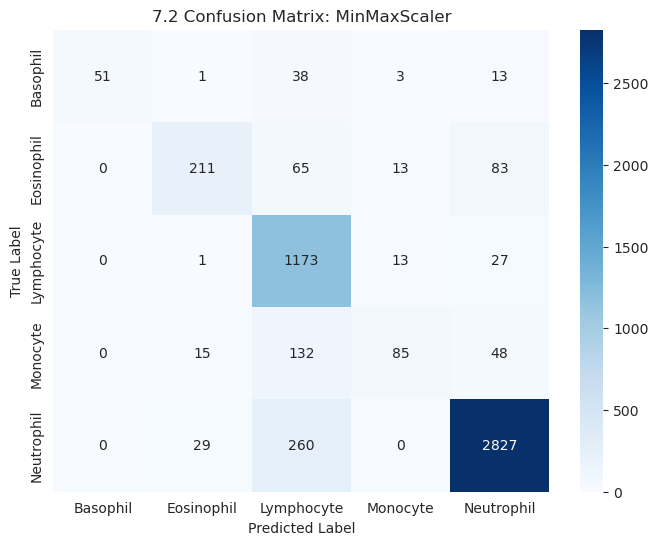

In [224]:
#----------------------------Standard-Scaled--------------------------
mlp = MLPClassifier(num_nodes_per_layer=[33, 30, 5], alpha=0.0001, lr=1.0, max_num_steps=300)
start_time = time.time()
mlp.fit(Xtrain7_scaled, y_train_hot7)
end_time = time.time()
time7a = end_time - start_time
y_preds = mlp.predict(Xtest7_scaled, hot=True)
accuracy = mlp.score(Xtest7_scaled, y_test_hot7)
print(f'Accuracy of standard-scaled data: {accuracy}')
f17a = mlp.f1_score(y_preds, y_test_hot7,)
print(f'F1 of standard-scaled data: {f17a}')

print("---------------------------------------------")
#----------------------------MinMax-Scaled--------------------------
start_time = time.time()
mlp.fit(Xtrain7_mm_scaled, y_train_hot7)
end_time = time.time()
time7b = end_time - start_time
y_pred = mlp.predict(Xtest7_mm_scaled, hot=True)
accuracy = mlp.score(Xtest7_mm_scaled, y_test_hot7)
print(f'Accuracy of MinMax-scaled data : {accuracy}')
f17b = mlp.f1_score(y_pred, y_test_hot7,)
print(f'F1 of MinMax-scaled data: {f17b}')


#-------------- confusion Matrix Standard-------------
y_preds = mlp.predict(Xtest7_scaled, hot=False)
class_labels = ['Basophil', 'Eosinophil','Lymphocyte', 'Monocyte', 'Neutrophil']
mlp.plot_confusion_matrix_multiclass(y_test_hot7, y_preds, class_labels, "7.1 Confusion Matrix: StandardScaler")
#---------------confusion Matrix MinMax-------------
y_pred = mlp.predict(Xtest7_mm_scaled, hot=False)
mlp.plot_confusion_matrix_multiclass(y_test_hot7, y_pred, class_labels, "7.2 Confusion Matrix: MinMaxScaler")

Abbildung 7.1 zeigt die Confusion Matrix der vorhergesagten Date, wenn das Modell mit StardardScaler gescaleten Daten Trainiert wurde und 7.2 mit MinMaxScaler. Der StandardScaler führt in diesem Test mot einem F1-SCore von 0.86 zu einem besseren Resultat als der MinMaxScaler. 
In beiden Fällen Klassifiziert das Model keine der Testdaten als Basophil, die Klasse mit geringster Vertretung in den Train&Test-Daten. Besser Vertretete Klassen wie Lymphocyte & Neutrophil werden öfters richtig Klassifiziert, jedoch auch sehr oft False-Positive. Am Häufigsten wird Lymphocyte False-Positve vorhergesagt.

#### Bestes Model:

MLPClassifier(num_nodes_per_layer=[33, 30, 5], alpha=0.0001, lr=1.0, max_num_steps=1000)
-Trainings und Testdaten mit StandardScaler scalen<br>
-Beste Parameter nehmen: num_nodes_per_layer=[33, 30, 5], alpha=0.0001, lr=1.0<br>

F1 of standard-scaled data: 0.9357311320754716


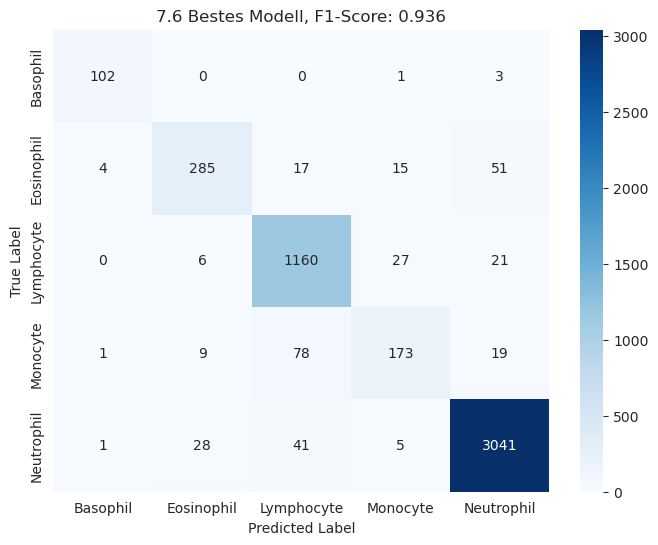

In [231]:
mlp = MLPClassifier(num_nodes_per_layer=[33, 30, 5], alpha=0.0001, lr=1.0, max_num_steps=1000)
start_time = time.time()
mlp.fit(Xtrain7_scaled, y_train_hot7)
end_time = time.time()
time7f = end_time - start_time
y_preds = mlp.predict(Xtest7_scaled, hot=True)
f17f = mlp.f1_score(y_preds, y_test_hot7,)
print(f'F1 of standard-scaled data: {f17f}')

y_preds = mlp.predict(Xtest7_scaled, hot=False)
class_labels = ['Basophil', 'Eosinophil','Lymphocyte', 'Monocyte', 'Neutrophil']
title = f'7.6 Bestes Modell, F1-Score: {f17f:.3f}'
mlp.plot_confusion_matrix_multiclass(y_test_hot7, y_preds, class_labels, title)

### Batchsizes
Der Perzeptron wird auf dem Blutzellendatensatz mit unterschiedlichen Batchsizes gefittet: 265, 128, 64, 32, 16, 8, 4, 2, 1. Die Entwicklung der Kostenfunktion von Training- und Testdaten wird über die Anzahl der Iterationen für jede Batchsize geplottet.

In [232]:
### BEGIN SOLUTION
from sklearn.preprocessing import StandardScaler, OneHotEncoder
train8 = bc_train.copy()
test8 = bc_test.copy()

Xtrain8 = train8.drop(["Class", "image filename"], axis=1).values
ytrain8 = train8["Class"].values  # Output variable

Xtest8 = test8.drop(["Class", "image filename"], axis=1).values   # Input features
ytest8 = test8["Class"].values  # Output variable
#-------------oneHotEncode y_true-------------
encoder = OneHotEncoder(sparse=False)  # Create one-hot encoder (sparse=False) or (sparse_output)???
y_train_hot8 = encoder.fit_transform(ytrain8.reshape(-1, 1))
y_test_hot8 = encoder.fit_transform(ytest8.reshape(-1, 1))

# -------------Standardize input features-------------
scaler = StandardScaler()
Xtrain8_scaled = scaler.fit_transform(Xtrain8)
Xtest8_scaled = scaler.fit_transform(Xtest8)

import time
batch_sizes = [265, 128, 64, 32, 16, 8, 4, 2, 1]


Batch size: 265, Laufzeit: 0.44 Sekunden
Batch size: 128, Laufzeit: 0.56 Sekunden
Batch size: 64, Laufzeit: 0.84 Sekunden
Batch size: 32, Laufzeit: 1.35 Sekunden
Batch size: 16, Laufzeit: 2.62 Sekunden
Batch size: 8, Laufzeit: 4.83 Sekunden
Batch size: 4, Laufzeit: 9.18 Sekunden
Batch size: 2, Laufzeit: 18.52 Sekunden
Batch size: 1, Laufzeit: 36.56 Sekunden


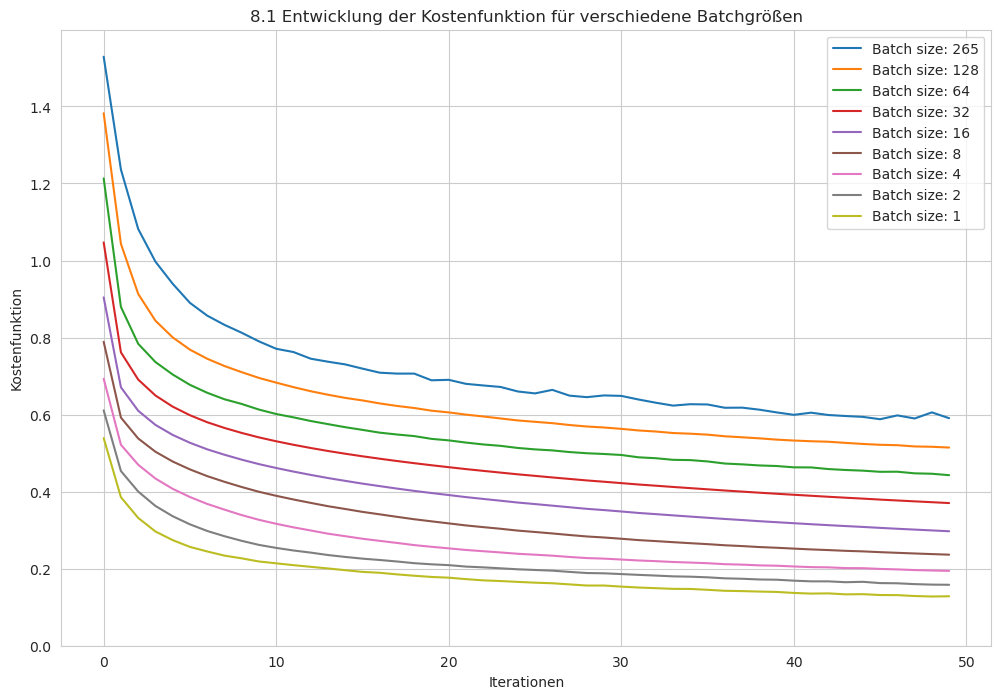

In [233]:


resultsMS = {}
#------------------train without target cost------------------
for batch_size in batch_sizes:
    mlp = MLPClassifier(num_nodes_per_layer=[33, 30, 5], batch_size=batch_size, max_num_steps=50)
    start_time = time.time()
    mlp.fit(Xtrain8_scaled, y_train_hot8)
    end_time = time.time()

    # ------------------Kostenfunktion über Iterationen------------------
    resultsMS[batch_size] = {
        "loss_curve": mlp.cost_,
        "time": end_time - start_time
    }

# ------------------Laufzeiten MaxSteps------------------
for batch_size, result in resultsMS.items():
    print(f"Batch size: {batch_size}, Laufzeit: {result['time']:.2f} Sekunden")

# ------------------Plot mit MaxSteps------------------
plt.figure(figsize=(12, 8))
for batch_size, result in resultsMS.items():
    plt.plot(result["loss_curve"], label=f"Batch size: {batch_size}")
plt.xlabel("Iterationen")
plt.ylabel("Kostenfunktion")
plt.title("8.1 Entwicklung der Kostenfunktion für verschiedene Batchgrößen")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

Das Model wurde mit verschiedenen Batch-sizes getestet und und bis zu einer bestimmten Anzahl Steps trainiert.<br>
Abbildung 8.1 Zeigt die Kosten nach Anzahl Steps im Trainingsverlauf, mit verschiedenen Batchsizes. 
Man sieht, dass mit niedrigeren Batch-sizes, ein kleinerer Loss erreicht wurde nach 50 steps. Die Laufzweit nahm jedoch auch exponentiell zu.


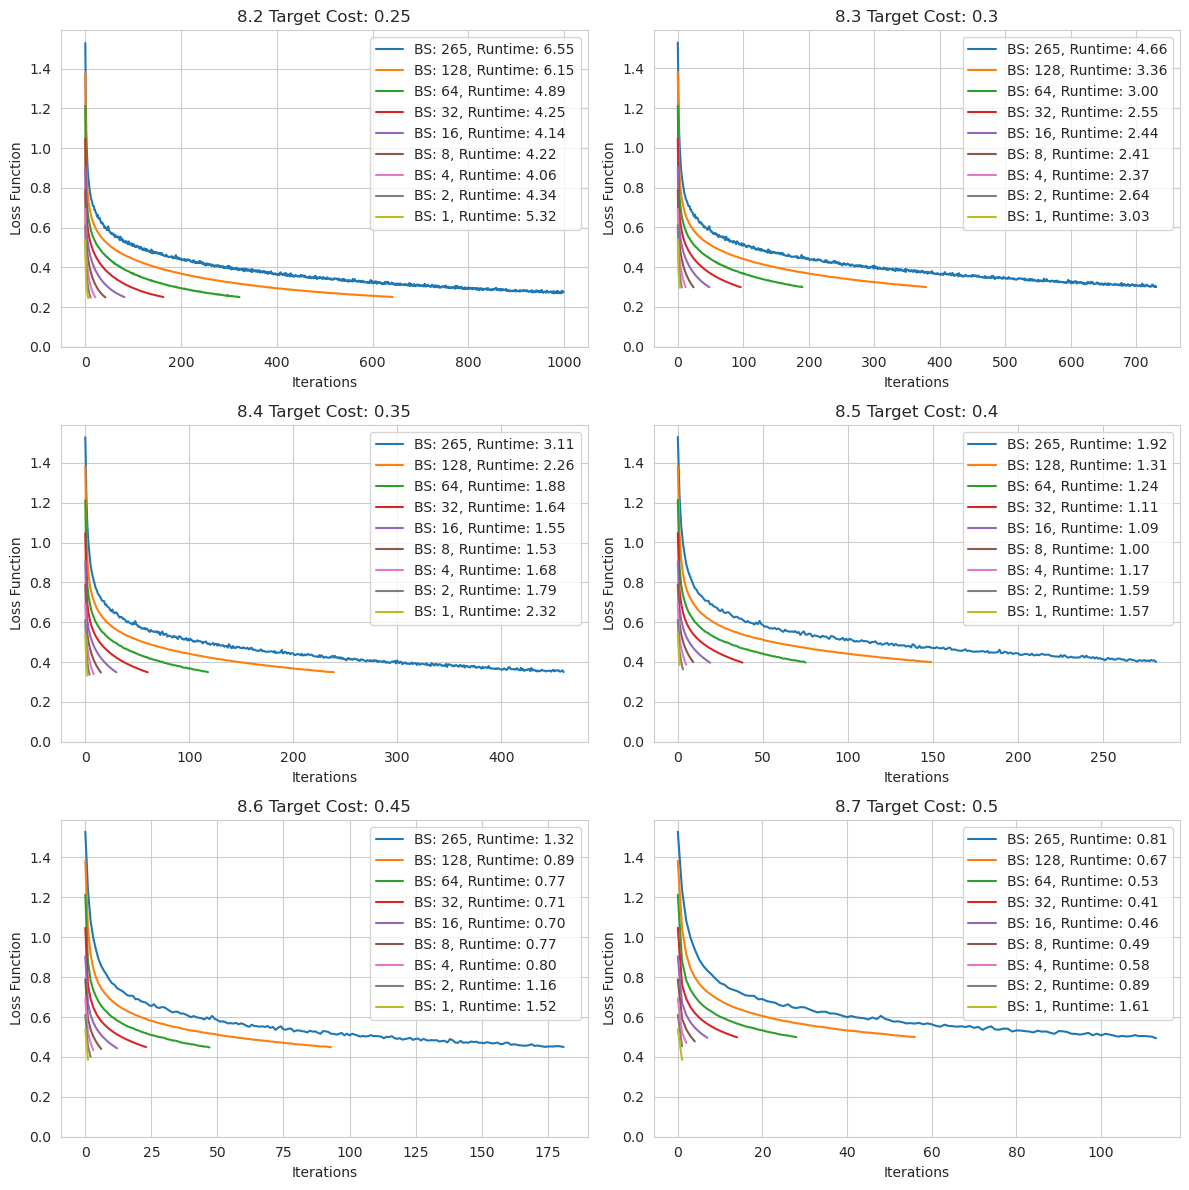

In [234]:
resultsTC = {}
target_costs=[0.25,0.3,0.35,0.4,0.45,0.5]

#------------------Train with target costs ------------------
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, target_cost in enumerate(target_costs):
    resultsTC = {}
    for batch_size in batch_sizes:
        mlp = MLPClassifier(num_nodes_per_layer=[33, 30, 5], batch_size=batch_size, max_num_steps=1000, target_cost=target_cost)
        start_time = time.time()
        mlp.fit(Xtrain8_scaled, y_train_hot8)
        end_time = time.time()
        # ------------------Kostenfunktion über Iterationen------------------
        resultsTC[batch_size] = {
            "loss_curve": mlp.cost_,
            "time": end_time - start_time
        }

    # ------------------Plot mit Target Cost------------------
    ax = axes[i]
    for batch_size, result in resultsTC.items():
        ax.plot(result["loss_curve"], label=f"BS: {batch_size}, Runtime: {result['time']:.2f}")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss Function")
    ax.set_title(f"8.{i+2} Target Cost: {target_cost}")
    ax.legend()
    ax.grid(True)
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()
### END SOLUTION

Abbildungen 8.2-8.7 zeigen die Kosten nach Anzahl Steps im Trainingsverlauf, von verschiedenen Batchsizes. Diesmal wurde jedoch das Training abgebrochen, nachdem ein gewisser Loss erreicht wurde um somit die Trainingszeit um einen gewissen Loss zu erreichen zu Messen und Vergleichen.<br><br>
Bei einem hohen Batch-size, brauchte es viele Steps um den gewünschten Loss zu erreichen, die einzelnen Steps dauern jedoch deutlich weniger lang. Mit kleineren Batch-sizes braucht es für jeden Step viel länger, die Kosten sind dafür nach viel weniger Steps sehr tief. <br><br>
Die schnellste Variante um auf einen tiefen Loss zu kommen ist in den Graphiken nicht zu 100% klar geworden, es zeigt sich jedoch ein Favorit mit der Batch-size 16, da dieser am öftesten die kürzeste Laufzeit hatte und auch am schnellsten auf den tiefsten Loss (Abb. 8.1: Loss=0.3) gekommen ist.

F1 of standard-scaled data: 0.94437893081761


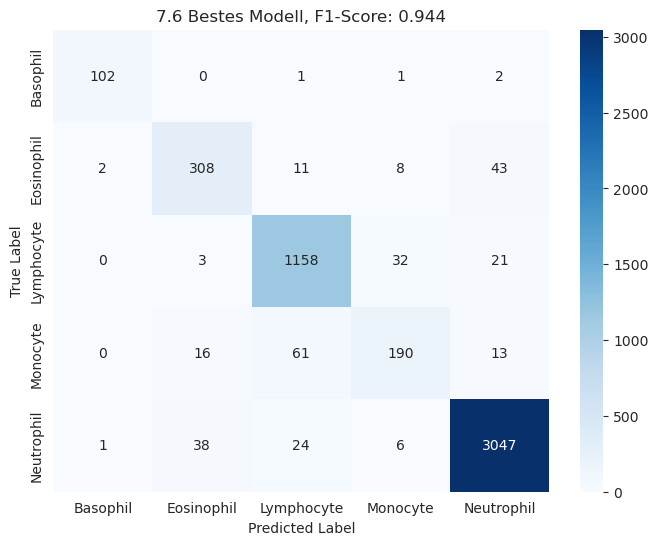

In [235]:
mlp = MLPClassifier(num_nodes_per_layer=[33, 30, 5], batch_size=16, max_num_steps=1000)
start_time = time.time()
mlp.fit(Xtrain8_scaled, y_train_hot8)
end_time = time.time()
time8 = end_time-start_time
y_preds = mlp.predict(Xtest8_scaled, hot=True)
f18 = mlp.f1_score(y_preds, y_test_hot8,)
print(f'F1 of standard-scaled data: {f18}')

y_preds = mlp.predict(Xtest8_scaled, hot=False)
class_labels = ['Basophil', 'Eosinophil','Lymphocyte', 'Monocyte', 'Neutrophil']
title = f'7.6 Bestes Modell, F1-Score: {f18:.3f}'
mlp.plot_confusion_matrix_multiclass(y_test_hot8, y_preds, class_labels, title)


### Weitere Klassifikationsalgorithmen

Nun werden weitere sinnvolle Klassifikations-Methoden Verglichen. 

In [236]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title="Confusionmatrix"):
    unique_classes = np.unique(np.concatenate((y_true, y_pred)))
    class_count = len(unique_classes)
    class_to_index = {class_name: index for index, class_name in enumerate(unique_classes)}
    cm = np.zeros((class_count, class_count), dtype=int)

    for true, pred in zip(y_true, y_pred):
        cm[class_to_index[true], class_to_index[pred]] += 1
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(unique_classes))
    plt.xticks(tick_marks, unique_classes, rotation=45)
    plt.yticks(tick_marks, unique_classes)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

class_names = ['Basophil', 'Eosinophil','Lymphocyte', 'Monocyte', 'Neutrophil']

def f1_score_ndarray(y_true, y_pred, classes):
    f1_scores =[]
    for class_name in classes:
        tp = ((y_true == y_pred) & (class_name == y_pred)).sum()
        fp = ((y_true != y_pred) & (class_name == y_pred)).sum()
        fn = ((y_true != y_pred) & (class_name != y_pred)).sum()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_scores.append( 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0)

    return np.mean(f1_scores)


Training und Optimierung von MLPClassifier...
Training und Optimierung von RandomForestClassifier...
Training und Optimierung von SVC...
Training und Optimierung von KNeighborsClassifier...

Ergebnisse für MLPClassifier:
  Beste Hyperparameter: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': 30, 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam', 'tol': 0.001}
  Bester F1-Score: 0.8756
  Trainingszeit: 23.746901750564575
  F1-Score auf Testdaten: 0.8751

 ------------------------------------------------------

Ergebnisse für RandomForestClassifier:
  Beste Hyperparameter: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
  Bester F1-Score: 0.8679
  Trainingszeit: 27.404197931289673
  F1-Score auf Testdaten: 0.8715

 ------------------------------------------------------

Ergebnisse für SVC:
  Beste Hyperparameter: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
  Bester F1-Score: 0.8762
  Trainingszeit: 6.82033109664917
  F1-Score auf Testdaten: 0

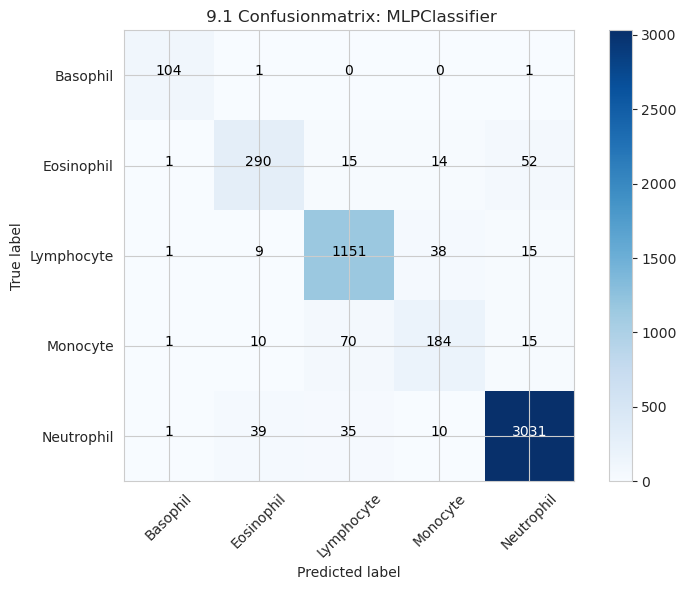

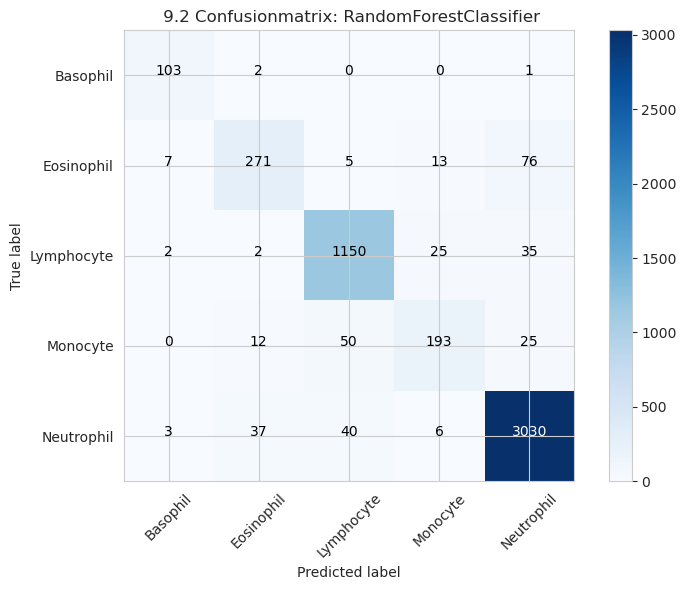

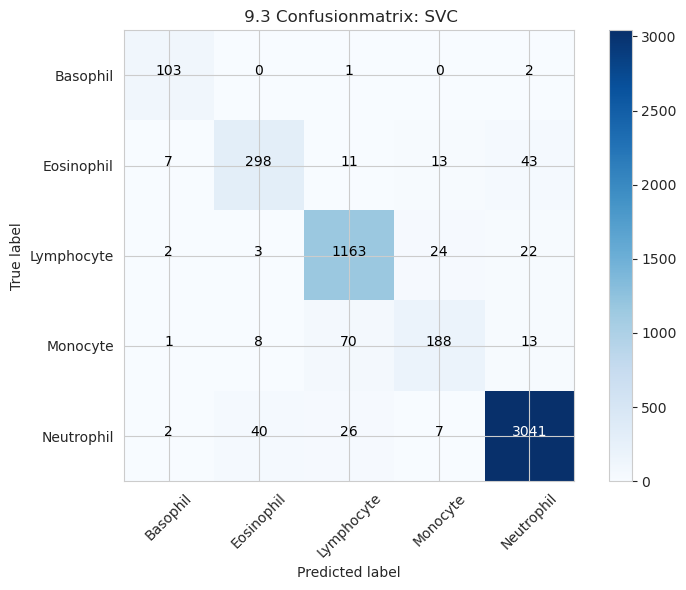

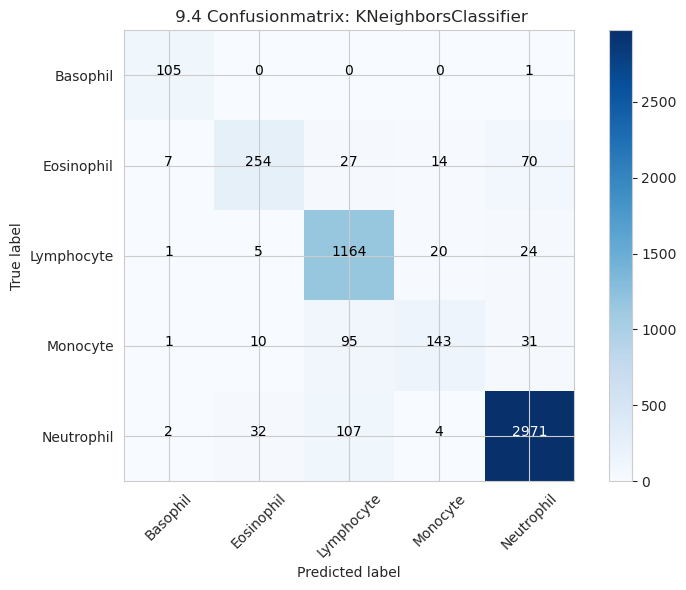

In [237]:
### BEGIN SOLUTION
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import seaborn as sns

train9 = bc_train.copy()
test9 = bc_test.copy()

Xtrain9 = train9.drop(["Class", "image filename"], axis=1)
ytrain9 = train9["Class"]  # Output variable

Xtest9 = test9.drop(["Class", "image filename"], axis=1)   # Input features
ytest9 = test9["Class"]  # Output variable

import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# ------------------OneHotEncoder------------------
encoder = OneHotEncoder(sparse=False)
y_train_hot = encoder.fit_transform(ytrain9.values.reshape(-1, 1))
y_test_hot = encoder.transform(ytest9.values.reshape(-1, 1))

# ------------------Standardisierung------------------
scaler = StandardScaler()
Xtrain9_scaled = scaler.fit_transform(Xtrain9)
Xtest9_scaled = scaler.transform(Xtest9)

#------------------Modelle und Hyperparameter-Grids------------------
models = {
    "MLPClassifier": {
        "model": MLPClassifier(),
        "params": {
            "hidden_layer_sizes": [(30)],
            "activation": ["relu", "tanh"],
            "solver": ["adam"],
            "alpha": [0.0001],
            "learning_rate": ["constant", "adaptive"],
            "max_iter": [1000],
            "tol": [1e-3],
        },
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [None, 5],
            "min_samples_split": [2, 5],
        },
    },
    "SVC": {
        "model": SVC(),
        "params": {
            "C": [1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale"],
        },
    },
    "KNeighborsClassifier": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],  # Anzahl der Nachbarn
            "weights": ["uniform", "distance"],  # Gewichtungsart
            "p": [1, 2],  # Distanzmetrik: 1=Manhattan, 2=Euklidisch
        },
    },
}

results = {}
scores=[]

#  ------------------Modelle testen und optimieren ------------------
for name, config in models.items():
    print(f"Training und Optimierung von {name}...")
    clf = GridSearchCV(config["model"], config["params"], scoring="f1_macro", cv=5)
    start_time = time.time()
    clf.fit(Xtrain9_scaled, ytrain9)
    end_time = time.time()
    results[name] = {
        "best_params": clf.best_params_,
        "best_score": clf.best_score_,
        "predictions": clf.predict(Xtest9_scaled),
        "training_time": end_time -start_time,
    }

#  ------------------ Ergebnisse auswerten ------------------
for name, result in results.items():
    print(f"\nErgebnisse für {name}:")
    print(f"  Beste Hyperparameter: {result['best_params']}")
    print(f"  Bester F1-Score: {result['best_score']:.4f}")
    print(f"  Trainingszeit: {result['training_time']}")

    #  ------------------F1-Score ------------------
    f1 = f1_score(ytest9, result["predictions"], average="macro")
    #f1 = f1_score_ndarray(ytest9, result["predictions"], class_names) 
    #-> gibt schlechte Werte aus; fehler noch nicht gefunden
    scores.append(f1)
    print(f"  F1-Score auf Testdaten: {f1:.4f}")
    print("\n ------------------------------------------------------")
i=1
for name, result in results.items():
    #  ------------------Confusion Matrix ------------------
    title = f' 9.{i} Confusionmatrix: {name}'
    plot_confusion_matrix(ytest9, result["predictions"], title)
    i=i+1

### END SOLUTION

### Übersicht der Resultate


In [238]:
import pandas as pd
# Daten für das DataFrame
daten = {
    'Aufgabe': ['Aufgabe 4', 'Aufgabe 4', 'Aufgabe 5', 'Aufgabe 7', 'Aufgabe 7', 'Aufgabe 7', 'Aufgabe 7', 'Aufgabe 7', 'Aufgabe 7', 'Aufgabe 8', 'Aufgabe 9', 'Aufgabe 9', 'Aufgabe 9', 'Aufgabe 9'],
    'Modelbeschreibung': ['Dummy-Klassifikator: Häufigste Klasse', 'Dummy-Klassifikator: Zufällig nach Klassenwahrscheinlichkeit', 'Logistische Regression', 'Beste Params, StandardScaler', 'Beste Params, MinMaxScaler', 'Beste Params, StandardScaler, ohne Ausreisser', 'Beste Params, MinMaxScaler, ohne Ausreisser', 'Beste Params, StandardScaler, Oversampled', 'Beste Params, StandardScaler, 1000 steps', 'Effektivster Batchsize', 'Scikit-MLP Classifier','RandomForest Classifier', 'SVC',  'KNeighbours Classifier'],
    'Max Steps': ["-", "-", "-", 300, 300, 300, 300, 300, 1000, 1000, 1000, "-", "-", "-"],
    'Trainingszeit': [1, 1.3, time5, time7a, time7b, time7c, time7d, time7e, time7f, time8,results["MLPClassifier"]["training_time"], results["RandomForestClassifier"]["training_time"], results["SVC"]["training_time"],  results["KNeighborsClassifier"]["training_time"]],
    'F1-Score': [frequ_f1, randomF1, f1_5, f17a, f17b, f17c, f17d, f17e, f17f, f18,scores[0],  scores[1], scores[2], scores[3]]
}
df = pd.DataFrame(daten)
df

,Aufgabe,Modelbeschreibung,Max Steps,Trainingszeit,F1-Score
0,Aufgabe 4,Dummy-Klassifikator: Häufigste Klasse,-,1.000000,0.151926
1,Aufgabe 4,Dummy-Klassifikator: Zufällig nach Klassenwahr...,-,1.300000,0.157187
2,Aufgabe 5,Logistische Regression,-,7.215792,0.179260
3,Aufgabe 7,"Beste Params, StandardScaler",300,4.421130,0.917649
4,Aufgabe 7,"Beste Params, MinMaxScaler",300,3.095134,0.854363
5,Aufgabe 7,"Beste Params, StandardScaler, ohne Ausreisser",300,6.329634,0.902712
6,Aufgabe 7,"Beste Params, MinMaxScaler, ohne Ausreisser",300,3.134246,0.871462
7,Aufgabe 7,"Beste Params, StandardScaler, Oversampled",300,0.335298,0.600039
8,Aufgabe 7,"Beste Params, StandardScaler, 1000 steps",1000,9.310344,0.935731
9,Aufgabe 8,Effektivster Batchsize,1000,55.184875,0.944379


*Tabelle wenn nötig auf 20 Reihen erweitern
**Laufzeit bei den Dummies wurde nicht effektiv gemessen, war jedoch sehr kurz, daher die Beispielwerte für visuelle Dartstellung

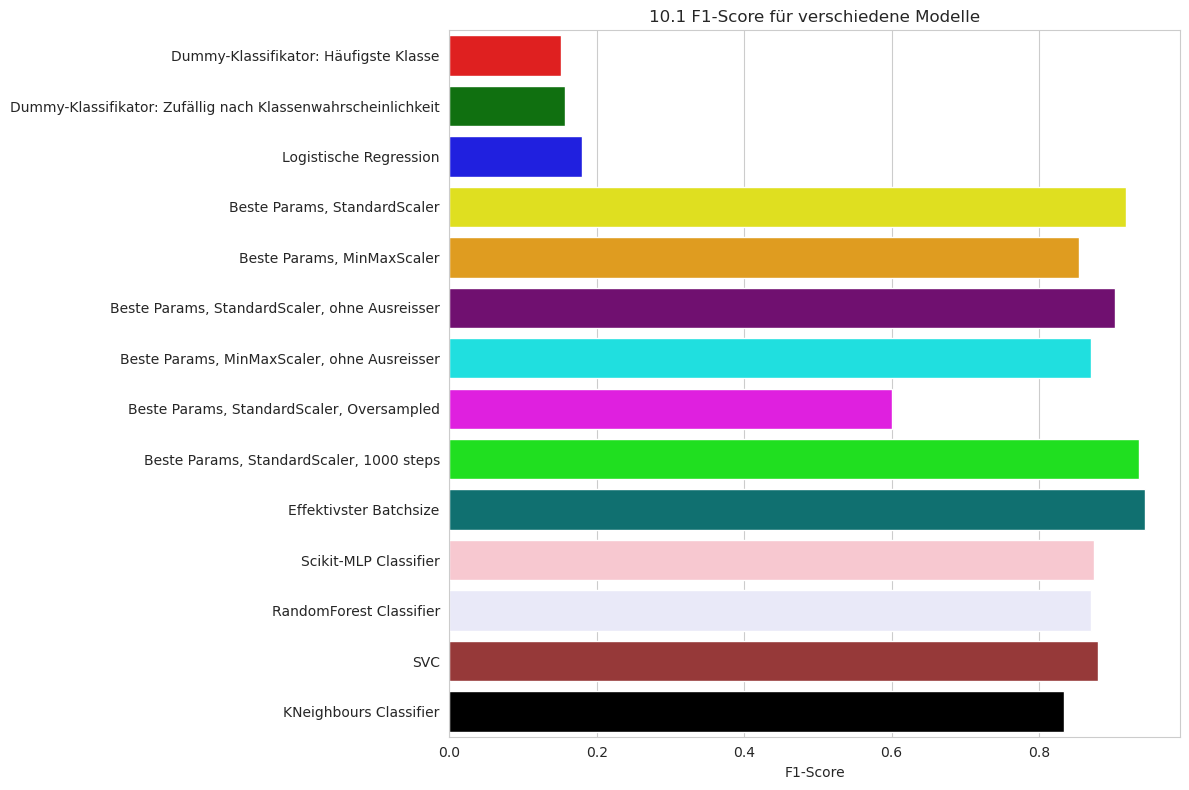

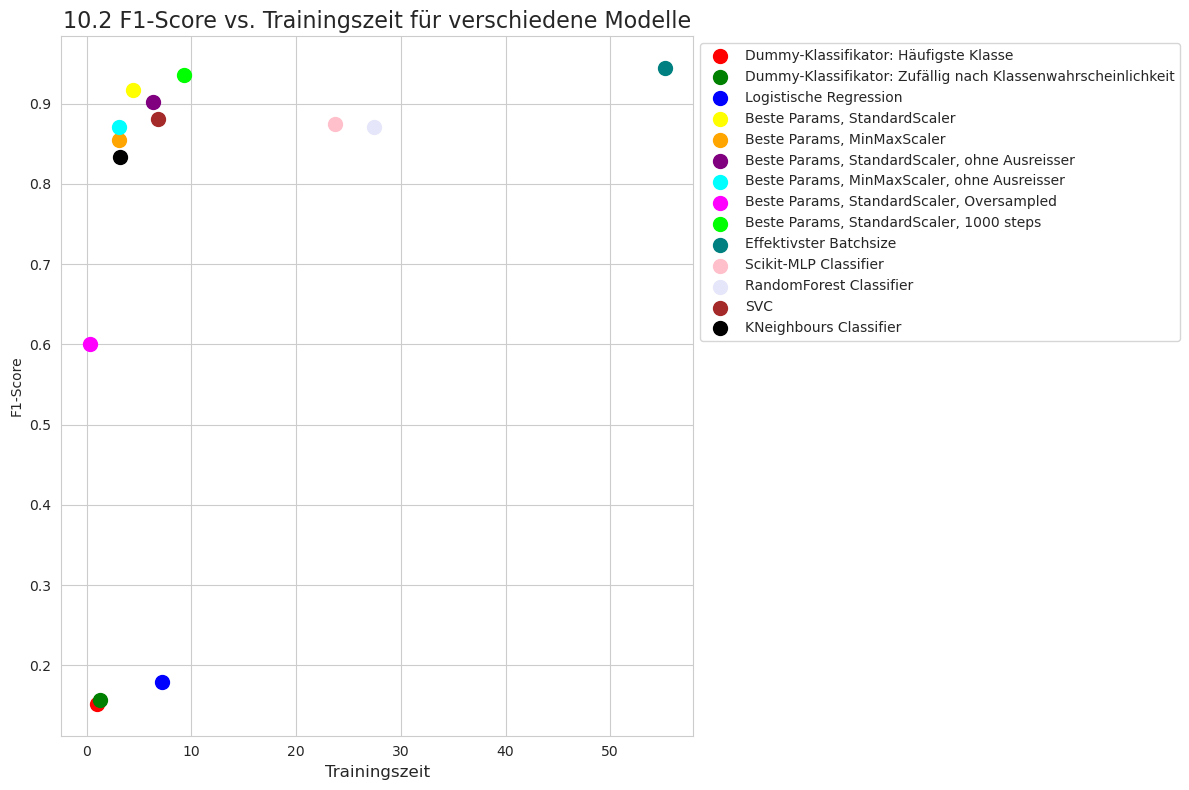

In [239]:
colors = ["red", "green", "blue", "yellow", "orange", "purple", "cyan", "magenta", "lime", "teal", "pink", "lavender", "brown", "black"]

plt.figure(figsize=(12, 8))
sns.barplot(x='F1-Score', y='Modelbeschreibung', data=df, palette=colors)

plt.xlabel('F1-Score')
plt.ylabel('')
plt.title('10.1 F1-Score für verschiedene Modelle', fontsize=12)

plt.tight_layout()
plt.show()

#----------------- F1-Score vs. Laufzeit -----------------
palette = sns.color_palette("husl", len(df))

plt.figure(figsize=(12, 8))

for i in range(len(df)):
    plt.scatter(df['Trainingszeit'][i], df['F1-Score'][i], color=colors[i], s=100, label=df['Modelbeschreibung'][i])

plt.xlabel('Trainingszeit', fontsize=12)
plt.ylabel('F1-Score')
plt.title('10.2 F1-Score vs. Trainingszeit für verschiedene Modelle', fontsize=16)
plt.grid(True)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In 10.1 ist der erreichte F1-Score der getesteten Modelle dargestellt.
In 10.2 wurde der F1-Score zusammen mit der Trainingszeit dargesteltt. Da einige (nicht alle) Modelle nur mit parametern getestet wurden, welche die Laufzeit niedrig halten, dient dieser Plot zur Hilfe, die F1-Scores richtig zu interpretieren.

##### Diskussion

An den Dummy-Klassifikatoren konnte man erkennen, dass die richtige Auswertungsmethode wichtig ist um die Güte eines Modells zu bestimmen. Der F1-Score hat sich die Vorhersage mehrerer Klassen als Aussagekräftig erwiesen und wurde daher in den folgenden Übungen verwendet. <br>
Die Logistische Regression erwies sich als ziemlich umbrauchbar für die Vorhersage mehrerer Klassen.<br>
Mit dem selbst geschriebenen MultilayerPerceptron, konnten einige gute Vorhersagen gemacht werden, daher diente er als Grundgerüst um dannach verschiedene Hyperparameter und Preprocessing Methoden auszuprobieren. <br>
Es wurde versucht auf bessere Vorhersagen zu kommen, indem Aussreisser in den Trainingsdaten eliminiert wurden und es wurde versucht mittels Oversampling versucht ein besseres Klassenverhältniss in den Trainingsdaten zu erhalten. Beide Methoden erzielten einen schlechteren F1-Score. Dies könnte jedoch auch an falscher Umsetzung liegen und könnte daher nochmals überprüft werden (z.B. Bei Oversampling alle Klassen auf genau gleich viele Werte bringen).<br>
Diese verarbeiteten Daten wurden jeweils noch mit dem StandardScaler und dem MinMaxScaler kombiniert, wobei der MinMaxScaler immer zu einem schlechteren F1-Score kam. <br>
Die besten Hyperparameter wurden mit einem GridSearch ermittelt, wobei aus Laufzeitgründen das Grid etwas kleiner gehalten wurde. Dies könnte noch stark erweitert werden für bessere Ergebnisse.<br>
Mit diesen Parametern und 1000 steps konnte ein relativ guter F1-Score von 0.936 erreicht werden und dass mit einer sehr kurzen Trainingszeit von 8.37s. <br>
Dannach wurde noch nach dem effektivsten Batch-size gesucht. Es gab dabei kein eindeutiges Ergebniss, da der schnellste Batch-size davon abhieng auf welchen Loss man kommen wollte. Es wurde daher ein Batch-size auf unsere Daten angewandt, welcher sich bei den meisten Versuchen als effektivster erwies. Es konnte damit ein leicht besserer F1-Score erreicht werden, jedoch erhöhte sich die Trainingszeit auch deutlich. <br>
Die Scikit-Modelle erziehlten alle schlechtere Ergebnisse als mein eigener MLPClassifier. <br>
Das Modell mit dem höchsten F1-Score war SVC. Es erzielte jedoch bei ähnlich langer traingingszeit einen deutlich niedrigeren F1-Score als mein MLPClassifier. Es wurde jedoch bei allen Modellen ein relativ kleines Grid getestet um die Laufzeit niedrig zu halten.